In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 0. EDA

In [2]:
real = pd.read_csv('../real.csv', index_col='No').reset_index(drop=True)
real.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [3]:
real.columns = ['date','house_age','dist_mrt','no_cvs','lat','long','price']
real.head()

,date,house_age,dist_mrt,no_cvs,lat,long,price
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [4]:
pd.unique(real['date'].apply(lambda x: (len(str(x)))))

array([18,  6,  7], dtype=int64)

제대로된 `date` 형식이 아닌 거 같다. 2012년인지 2013년인지만 나누기로

In [5]:
real['date'] = pd.Series([str(x)[:4] for x in real['date']]).astype('category')

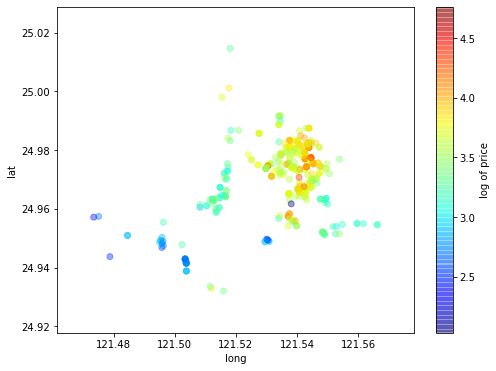

In [6]:
fig = plt.figure(figsize = (8, 6))
plt.scatter(x=real.long, y=real.lat, alpha=.4, c=np.log(real.price), cmap=plt.get_cmap('jet'))
plt.xlabel('long')
plt.ylabel('lat')
cbar = plt.colorbar()
cbar.ax.set_ylabel("log of price")
plt.show()

집값이 비싼 지역이 몰려 있는듯

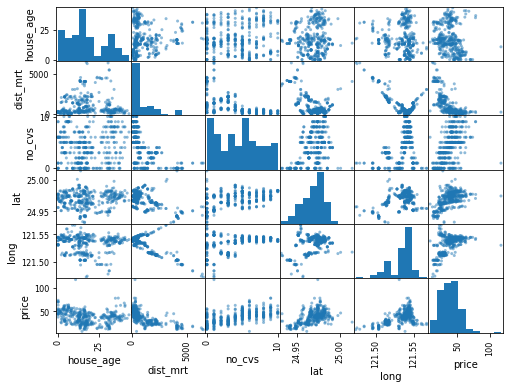

In [7]:
from pandas.plotting import scatter_matrix

scatter_matrix(real, figsize=(8,6))
plt.show()

`price`가 skewed된 모양이니 log를 취해준다

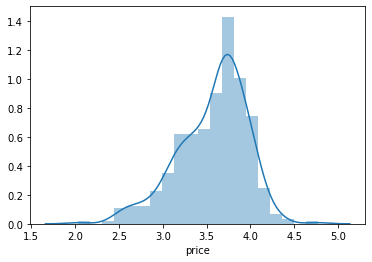

In [8]:
sns.distplot(np.log(real.price))
plt.show()

그나마 보기가 좀 나아진듯,, linear regression을 해줄 것이므로 타겟은 정규분포와 가까운 분포를 해야 모델 적합이 잘된다
마지막으로 date 변수를 year로 rename하고 더미변수로 변환해준다

In [9]:
real['year'] = real['date']
real.drop(['date'], axis=1, inplace=True)

real['log_price'] = np.log(real['price'])
real.drop(['price'], axis=1, inplace=True)

In [10]:
real = pd.get_dummies(real)
real.head()

,house_age,dist_mrt,no_cvs,lat,long,log_price,year_2012,year_2013
0,32.0,84.87882,10,24.98298,121.54024,3.634951,1,0
1,19.5,306.59470,9,24.98034,121.53951,3.742420,1,0
2,13.3,561.98450,5,24.98746,121.54391,3.856510,0,1
3,13.3,561.98450,5,24.98746,121.54391,4.003690,0,1
4,5.0,390.56840,5,24.97937,121.54245,3.763523,1,0


In [11]:
real = real[['house_age', 'dist_mrt', 'no_cvs', 'lat', 'long', 'year_2012', 'year_2013','log_price']]
real.head()

,house_age,dist_mrt,no_cvs,lat,long,year_2012,year_2013,log_price
0,32.0,84.87882,10,24.98298,121.54024,1,0,3.634951
1,19.5,306.59470,9,24.98034,121.53951,1,0,3.742420
2,13.3,561.98450,5,24.98746,121.54391,0,1,3.856510
3,13.3,561.98450,5,24.98746,121.54391,0,1,4.003690
4,5.0,390.56840,5,24.97937,121.54245,1,0,3.763523


# 1. train/test set 나누기

In [12]:
from sklearn.model_selection import train_test_split

X, y = real.iloc[:, :-1], real.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(331, 7) (331,)
(83, 7) (83,)


# 2. Polynomial Basis Feature Extraction
## 2-1. Scailing for numerical variables

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numeric_x = ['house_age', 'dist_mrt', 'no_cvs']

ct = ColumnTransformer([("scailing", StandardScaler(), numeric_x)], remainder='passthrough')
X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

## 2-2. Feature Extraction

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

def poly_reg(X, y, index, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    linear = LinearRegression()
    linear.fit(X, y)
    linear_poly = LinearRegression()
    tmp = poly.fit_transform(X[:, [index]])[:, [1]]
    X_poly = np.concatenate([X, tmp], axis=1)
    linear_poly.fit(X_poly, y)
    linear_pred, linear_poly_pred = linear.predict(X), linear_poly.predict(X_poly)
    return mean_squared_error(y, linear_pred) /  mean_squared_error(y, linear_poly_pred)

In [15]:
from functools import partial

indexs = list(range(2))
list(map(partial(poly_reg, X_train_scaled, y_train), indexs))

[1.0716176166711844, 1.063903941990996]

mse가 7%, 6% 정도 차이나니 별로 효과는 없어보인다. polynomial은 안넣기로 했다

# 3. Ridge, Lasso Regression

In [16]:
from sklearn.linear_model import RidgeCV, LassoCV

alphas = np.logspace(-1, 1, num=5)
ridgecv = RidgeCV(alphas=alphas, cv=5, fit_intercept=False)
lassocv = LassoCV(alphas=alphas, cv=5, fit_intercept=False)

ridgecv.fit(X_train_scaled, y_train)
lassocv.fit(X_train_scaled, y_train)

print(ridgecv.score(X_test_scaled, y_test))
print(lassocv.score(X_test_scaled, y_test))

0.768517337067544
0.5836894164921249


C:\Users\subon\Desktop\anaconda\envs\test\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45406012564908593, tolerance: 0.42607915157554227
  positive)


In [17]:
ridgecv.alpha_, lassocv.alpha_

(0.1, 0.1)

릿지라쏘 둘다 람다값은 0.1이 적정한 것으로 보인다

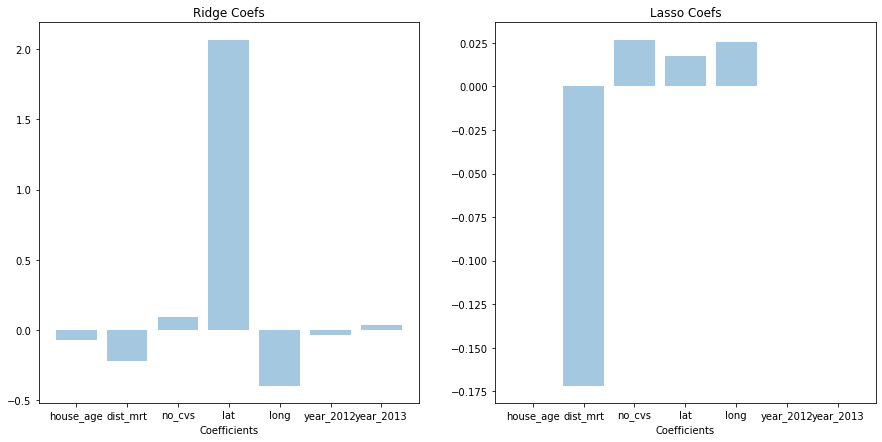

In [18]:
labels = list(X_train.columns)
index = np.arange(len(labels))
titles = ['Ridge Coefs', 'Lasso Coefs']
coefs = [ridgecv.coef_, lassocv.coef_]

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
for idx, ax in enumerate(axes):
    ax.bar(index, coefs[idx], alpha=.4)
    ax.set_xlabel("Coefficients")
    ax.set_xticks(index)
    ax.set_xticklabels(labels, )
    ax.set_title(titles[idx])

가장 중요한 변수는 R^2 score로 확인해보자

In [19]:
class ridge:
    def __init__(self, alpha):
        from sklearn.linear_model import Ridge
        self.alpha = alpha
        self.explained_variance_ratio = []
        self.estimator = Ridge(alpha=alpha)
        
    def fit(self, X, y, *, indices: 'iterable'):
        from collections import Iterable
        from sklearn.metrics import r2_score
        assert isinstance(indices, Iterable)
        for indice in indices:
            self.estimator.fit(X[:, [indice]], y)
            pred = self.estimator.predict(X[:, [indice]])
            r2 = 1-(y-pred).var() / y.var()
            self.explained_variance_ratio.append(r2)
        return self.explained_variance_ratio
    
class lasso(ridge):
    def __init__(self, alpha):
        from sklearn.linear_model import Lasso
        self.alpha = alpha
        self.explained_variance_ratio = []
        self.estimator = Lasso(alpha=alpha)

In [20]:
ridge(0.1).fit(X_train_scaled, y_train, indices=range(X_train_scaled.shape[1]))

C:\Users\subon\Desktop\anaconda\envs\test\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if __name__ == '__main__':


[0.04114698281475515,
 0.5404284280056799,
 0.3485705388137391,
 0.2144067749872801,
 0.23148967947518906,
 0.0020649648336613646,
 0.0020649648336613646]

In [21]:
lasso(0.1).fit(X_train_scaled, y_train, indices=range(X_train_scaled.shape[1]))

[0.0, 0.47549369835064514, 0.28363579165776587, 0.0, 0.0, 0.0, 0.0]

R^2 score로 확인해본 결과 ridge에서는 `dist_mrt`가 제일 중요하고 lasso에서도 마찬가지! <br>
아래는 그림으로 확인해본 건데 `dist_mrt, no_cvs`이 두개가 핵심 변수인듯 하다

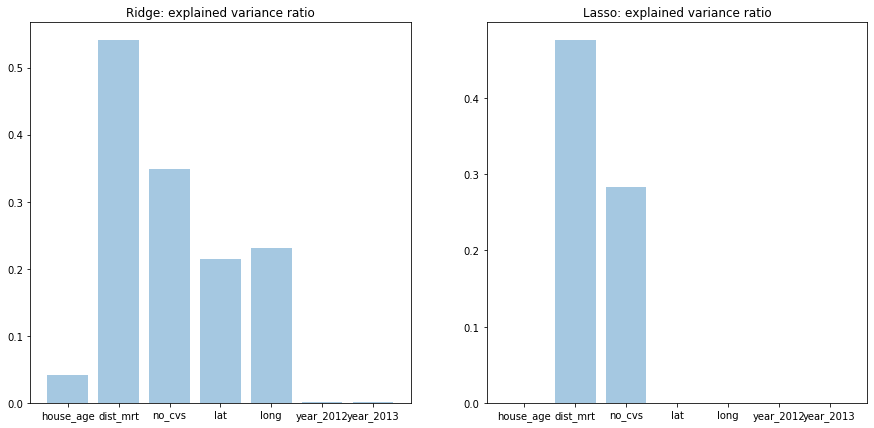

In [22]:
ridge_r2 = ridge(0.1).fit(X_train_scaled, y_train, indices=range(X_train_scaled.shape[1]))
lasso_r2 = lasso(0.1).fit(X_train_scaled, y_train, indices=range(X_train_scaled.shape[1]))
r2 = [ridge_r2, lasso_r2]
labels = list(X_train.columns)
index = np.arange(len(labels))
titles = ['Ridge: explained variance ratio', 'Lasso: explained variance ratio']

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
for idx, ax in enumerate(axes):
    ax.bar(index, r2[idx], alpha=.4)
    ax.set_xticks(index)
    ax.set_xticklabels(labels)
    ax.set_title(titles[idx])

# 4. GeoPandas

In [23]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [24]:
map1 = gpd.read_file('../지도자료 landuse/landuse.shp')
map2 = gpd.read_file('../지도자료 places/places.shp')
map3 = gpd.read_file('../지도자료 roads/roads.shp')

In [25]:
crs = {'init':'espc:4326'}
geometry = [Point(xy) for xy in zip(real.long, real.lat)]
geo_df = gpd.GeoDataFrame(real, crs= crs, geometry=geometry)

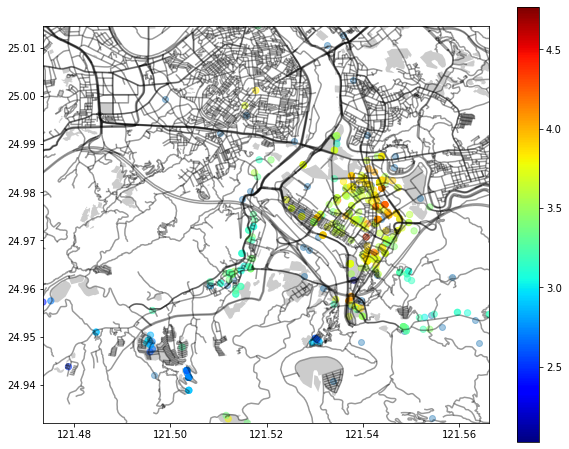

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
map1.plot(ax=ax, alpha=0.4, color='grey')
map2.plot(ax=ax, alpha=0.4)
map3.plot(ax=ax, alpha=0.4, color='black')
geo_df.plot(column='log_price',ax=ax,alpha=0.5, legend=True,
            markersize=40, cmap=plt.get_cmap('jet'))
plt.ylim(min(real.lat), max(real.lat))
plt.xlim(min(real.long), max(real.long))
plt.show()